## Lab 2

### Part 3. Poetry generation

Let's try to generate some poetry using RNNs. 

You have several choices here: 

* The Shakespeare sonnets, file `sonnets.txt` available in the notebook directory.

* Роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина. В предобработанном виде доступен по [ссылке](https://github.com/attatrol/data_sources/blob/master/onegin.txt).

* Some other text source, if it will be approved by the course staff.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


In [28]:
import string
import os

### Data loading: Shakespeare

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`). Simple preprocessing is already done for you in the next cell: all technical info is dropped.

In [29]:
if not os.path.exists('sonnets.txt'):
    !wget https://raw.githubusercontent.com/girafe-ai/ml-mipt/master/homeworks_basic/Lab2_DL/sonnets.txt

with open('sonnets.txt', 'r') as iofile:
    text = iofile.readlines()
    
TEXT_START = 45
TEXT_END = -368
text = text[TEXT_START : TEXT_END]
assert len(text) == 2616

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [35]:
text_join = ''.join(text)

In [36]:
len(text_join)

100225

In [37]:
# Join all the strings into one and lowercase it
# Put result into variable text.

# Your great code here
text = ''.join(text).lower()
assert len(text) == 100225, 'Are you sure you have concatenated all the strings?'
assert not any([x in set(text) for x in string.ascii_uppercase]), 'Uppercase letters are present'
print('OK!')

OK!


### Data loading: "Евгений Онегин"


In [ ]:
!wget https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt
    
with open('onegin.txt', 'r') as iofile:
    text = iofile.readlines()
    
text = [x.replace('\t\t', '') for x in text]

--2020-05-10 19:02:32--  https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.244.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.244.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 262521 (256K) [text/plain]
Saving to: ‘onegin.txt’

onegin.txt          100%[===================>] 256.37K  --.-KB/s    in 0.1s    

2020-05-10 19:02:33 (2.25 MB/s) - ‘onegin.txt’ saved [262521/262521]



In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [ ]:
# Join all the strings into one and lowercase it
# Put result into variable text.

# Your great code here


Put all the characters, that you've seen in the text, into variable `tokens`.

In [38]:
tokens = sorted(set(text))

In [39]:
type(tokens)

list

Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [67]:
# dict <index>:<char>
# Your great code here
token_to_idx = {char: index for (char, index) in zip(tokens, list(range(len(tokens))))}
# dict <char>:<index>
# Your great code here
idx_to_char = {index: char for (char, index) in zip(tokens, list(range(len(tokens))))}

*Comment: in this task we have only 38 different tokens, so let's use one-hot encoding.*

### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

In [74]:
# Your code here

import torch, torch.nn as nn
import time
from torch.optim import lr_scheduler, Adam
import torch.nn.functional as F
import numpy as np

In [69]:
from IPython.display import clear_output
from random import sample
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt

In [49]:
class RNN(nn.Module):
    
    def __init__(self, num_tokens=len(token_to_idx), embedding_size=100, rnn_num_units=200):
        super(self.__class__,self).__init__()
        self.num_units = rnn_num_units
        
        self.embedding = nn.Embedding(num_tokens, embedding_size)
        self.rnn_update = nn.Linear(embedding_size + rnn_num_units, rnn_num_units)
        self.rnn_to_logits = nn.Linear(rnn_num_units, num_tokens)
        self.activation = nn.PReLU(num_parameters=self.num_units)
        
    def forward(self, x, h_prev):
        """
        This method computes h_next(x, h_prev) and log P(x_next | h_next)
        We'll call it repeatedly to produce the whole sequence.
        
        :param x: batch of character ids, containing vector of int64
        :param h_prev: previous rnn hidden states, containing matrix [batch, rnn_num_units] of float32
        """

        x_emb = self.embedding(x)
        x_and_h = torch.cat([x_emb, h_prev], dim=-1)
        h_next = self.rnn_update(x_and_h)
        
        h_next = self.activation(h_next)
        logits = self.rnn_to_logits(h_next)
        
        return h_next, F.log_softmax(logits, -1)
    
    def initial_state(self, batch_size):
        return torch.randn(batch_size, self.num_units, requires_grad=True).to(device)

In [50]:
def to_matrix(tok_to_id, text, samples_num=5000, batch_len=300):
    
    return torch.tensor([[tok_to_id[tok] for tok in text[start:start+batch_len]]
            for start in torch.randint(0, len(text) - batch_len, (samples_num,))]).to(device)

In [51]:
def rnn_loop(char_rnn, batch_ix):
    """
    Computes log P(next_character) for all time-steps in names_ix
    :param names_ix: an int32 matrix of shape [batch, time], output of to_matrix(names)
    """
    batch_size, max_length = batch_ix.size()
    hid_state = char_rnn.initial_state(batch_size)
    logprobs = []

    for x_t in batch_ix.transpose(0,1):
        hid_state, logp_next = char_rnn(x_t, hid_state)  # <-- here we call your one-step code
        logprobs.append(logp_next)
        
    return torch.stack(logprobs, dim=1)

In [55]:
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')

In [59]:
batch_size = 200
model = RNN()
dataloader = DataLoader(to_matrix(token_to_idx, text), batch_size=batch_size, shuffle=True)
optimizer = torch.optim.Adam(model.parameters(), lr=2e-3, weight_decay=1e-3)
criterion = nn.CrossEntropyLoss()
scheduler = lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.7)

In [60]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=100):
    
    since = time.time()
    model.to(device)
    model.train()
    
    losses = []
    for epoch in range(num_epochs):

        running_loss = 0.0

        for inputs in dataloader:
            
            inputs = inputs.to(device)
            
            optimizer.zero_grad()
            logp_seq = rnn_loop(model, inputs)
            #predictions_logp = logp_seq[:, :-1]
            #actual_next_tokens = inputs[:, 1:]

            logp_next = torch.gather(logp_seq[:, :-1], dim=2, index=inputs[:, 1:][:,:,None])

            loss = -logp_next.mean()
            loss.backward()
            
            optimizer.step()
            optimizer.zero_grad()
            running_loss += loss

        scheduler.step()

        epoch_loss = running_loss / len(dataloader)
        losses.append(epoch_loss)
        clear_output(True)
        plt.plot(losses, label='current loss: {:.2}'.format(epoch_loss))
        plt.legend()
        plt.show()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    
    return model, losses

Plot the loss function (axis X: number of epochs, axis Y: loss function).

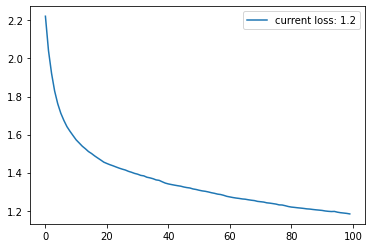

Training complete in 44m 13s


In [70]:
# Your plot code here
model, losses = train_model(model, criterion, optimizer, scheduler)

In [72]:
def generate_sample(char_rnn, seed_phrase='hello my friends, ', max_length=500, temperature=1.0):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
                        smaller temperature converges to the single most likely output
    '''
    
    x_sequence = [token_to_idx[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64, device=device)
    hid_state = char_rnn.initial_state(batch_size=1)
    char_rnn.eval()
    
    for i in range(len(seed_phrase) - 1):
        hid_state, _ = char_rnn(x_sequence[:, i], hid_state)
    
    for _ in range(max_length - len(seed_phrase)):
        hid_state, logp_next = char_rnn(x_sequence[:, -1], hid_state)
        p_next = F.softmax(logp_next / temperature, dim=-1).data.cpu().numpy()[0]
        
        next_ix = np.random.choice(len(token_to_idx), p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64, device=device)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)
        
    return ''.join([tokens[ix] for ix in x_sequence.data.cpu().numpy()[0]])

In [75]:
print(generate_sample(model, seed_phrase='hello my friends, i want to say that', 
                      max_length=500, temperature=0.5))

hello my friends, i want to say that the truth's lose, then happy i show, when the give the self thou days are of diest the merit the may,
    that thou best be the time more love's first, and shall not farther than your was not spend.
  now sing thou art the strangely be the sweet that shall be that so it suberre that thy self as ext'st thou the comment, and love and thee,
  though the stall where where the the will be grow
  to his abling pend,
  and so should leven the leaves in thy self is b


In [ ]:
# An example of generated text.
# print(generate_text(length=500, temperature=0.2))

hide my will in thine?
  shall will in of the simend that in my sime the seave the seave the sorll the soren the sange the seall seares and and the fart the wirl the seall the songh whing that thou hall will thoun the soond beare the with that sare the simest me the fart the wirl the songre the with thy seart so for shat so for do the dost the sing the sing the sing the soond canding the sack and the farling the wirl of sore sich and that with the seare the seall so fort the with the past the wirl the simen the wirl the sores the sare


### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

Plot the loss function of the number of epochs. Does the final loss become better?

In [83]:
# Your beautiful code here
class LSTM(nn.Module):
    
    def __init__(self, num_tokens=len(token_to_idx), embedding_size=100, rnn_num_units=200):
        super(self.__class__, self).__init__()
        self.num_units = rnn_num_units
        self.embedding = nn.Embedding(num_tokens, embedding_size)
        
        self.lstm = nn.LSTMCell(embedding_size, rnn_num_units)
        self.fc = nn.Linear(in_features=rnn_num_units, out_features=len(token_to_idx))
        
    def forward(self, x, h_prev, c_prev):
        """
        This method computes h_next(x, h_prev) and log P(x_next | h_next)
        We'll call it repeatedly to produce the whole sequence.
        
        :param x: batch of character ids, containing vector of int64
        :param h_prev: previous rnn hidden states, containing matrix [batch, rnn_num_units] of float32
        """
        x_emb = self.embedding(x)
        h, c = self.lstm(x_emb, (h_prev, c_prev))
        
        output = self.fc(h)
        
        return h, c, F.log_softmax(output, -1)
    
    def initial_state(self, batch_size):
        return torch.randn(batch_size, self.num_units, requires_grad=True).to(device), \
               torch.randn(batch_size, self.num_units, requires_grad=True).to(device)

In [84]:
def lstm_loop(model, batch_ix):
    """
    Computes log P(next_character) for all time-steps in names_ix
    :param names_ix: an int32 matrix of shape [batch, time], output of to_matrix(names)
    """
    batch_size, max_length = batch_ix.size()
    hid_state, cell_state = model.initial_state(batch_size)
    logprobs = []

    for x_t in batch_ix.transpose(0, 1):
        hid_state, cell_state, logp_next = model(x_t, hid_state, cell_state)  # <-- here we call your one-step code
        logprobs.append(logp_next)
        
    return torch.stack(logprobs, dim=1)

In [85]:
model = LSTM()
dataloader = DataLoader(to_matrix(token_to_idx, text), batch_size=batch_size, shuffle=True)
optimizer = torch.optim.Adam(model.parameters(), lr=2e-1, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
scheduler = lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

In [88]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=50):
    
    since = time.time()
    model.to(device)
    model.train()
    
    losses = []
    for epoch in range(num_epochs):

        running_loss = 0.0

        for inputs in dataloader:
            
            inputs = inputs.to(device)
            
            optimizer.zero_grad()
            logp_seq = lstm_loop(model, inputs)
            predictions_logp = logp_seq[:, :-1]
            actual_next_tokens = inputs[:, 1:]

            logp_next = torch.gather(predictions_logp, dim=2, index=actual_next_tokens[:,:,None])

            loss = -logp_next.mean()
            loss.backward()
            
            optimizer.step()
            optimizer.zero_grad()
            running_loss += loss

        scheduler.step()

        epoch_loss = running_loss / len(dataloader)
        losses.append(epoch_loss)
        clear_output(True)
        plt.plot(losses, label='current loss: {:.2}'.format(epoch_loss))
        plt.legend()
        plt.show()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    
    return model, losses

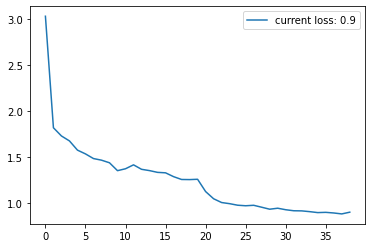

KeyboardInterrupt: ignored

In [89]:
model, losses = train_model(model, criterion, optimizer, scheduler)

Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

In [90]:
# Text generation with different temperature values here
def generate_text(model, init=' Hide my will', length=256, temperature=1.0):

    x_sequence = [token_to_idx[token] for token in init]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64, device=device)
    hid_state, cell_state = model.initial_state(batch_size=1)
    model.eval()
    
    for i in range(len(init) - 1):
        hid_state, cell_state, _ = model(x_sequence[:, i], hid_state, cell_state)
    
    for _ in range(length - len(init)):
        hid_state, cell_state, logp_next = model(x_sequence[:, -1], hid_state, cell_state)
        p_next = F.softmax(logp_next / temperature, dim=-1).data.cpu().numpy()[0]
        
        next_ix = np.random.choice(len(token_to_idx), p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64, device=device)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)
        
    return ''.join([tokens[ix] for ix in x_sequence.data.cpu().numpy()[0]])

In [91]:
print("Generated texts:")

for temp in [0.1, 0.2, 0.5, 1.0, 2.0]:
    print(generate_text(model, init='please, go to ', length=100, temperature=temp))
    print("-"*20)

Generated texts:
please, go to me, not forth where thou art so muse,
  and shows not solen in the sun other part:
   
--------------------
please, go to me groand;
  and see that thou see'int one own worth to his sweet self to praise.

  x
--------------------
please, go to with the spring,
  when thou thine on thy beauty doth even
  what his in thee hath tha
--------------------
please, go to make my leaves qoly.

  xlave sweet love i was tme dead flame of self-love'st.

  xix

--------------------
please, go to me.k dicin thy ygy spenfitgers would kzawhwarratq!
  bake qucwing abvisinxxage; it pin
--------------------


### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a> 
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch`)